In [231]:
#imports
from matplotlib import colors
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
from math import sqrt

<center><h1>Reputation Based Peer Assessment</h1></center>
<center><h2>Iterative Ranking with Reputation Redistribution Applied to Peer Grades</h2></center>
<center>Stephen Baldwin</center>
<center>stephen.baldwin@gatech.edu</center>

# Data Exploration

In [232]:
# LOAD DATA
instructor_grades = pd.read_csv('./dataset/grades_instructors_all.tsv', sep='\t')
student_grades = pd.read_csv('./dataset/grades_students_all.tsv', sep='\t')
student_reports = pd.read_csv('./dataset/students_reports_mapping.tsv', sep='\t')

In [233]:
# CREATE STUDENT GRAPH

## get nodes from data
students = student_reports['student_id'].unique()
reports = student_reports['report_id'].unique()

## get edges from data
grades = [tuple([x[0], x[1], { 'grade': x[2] }]) for x in student_grades.values]

## create Graph
P = nx.Graph()
P.add_nodes_from(students, reputation=1/60, bipartite=0)
P.add_nodes_from(reports, quality=1, bipartite=1)
P.add_edges_from(grades)

/Users/joey/Development/peerAssessment/env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/joey/Development/peerAssessment/env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/joey/Development/peerAssessment/env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


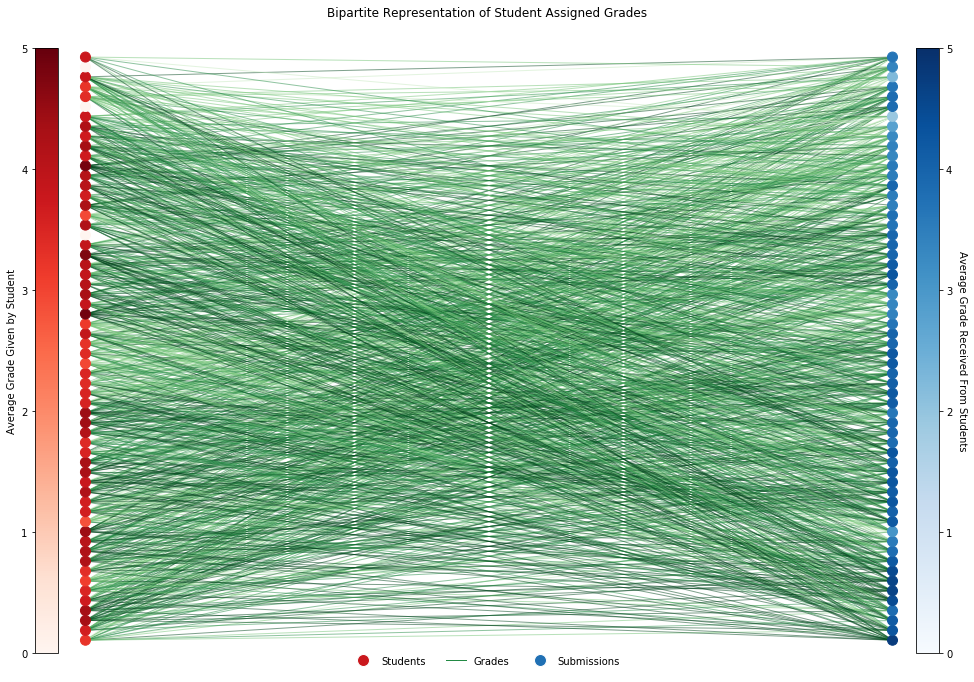

In [234]:
# BIPARTITE VISUALIZATION OF STUDENT GRADES

## update node positions
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(students) )
pos.update( (n, (2, i)) for i, n in enumerate(reports) )
fig, ax = plt.subplots(1,figsize=(16,12))

## draw nodes
weights = [ 0 if x[1] == 0 else x[1] / P.degree(x[0]) for x in P.degree(students, weight='grade') ]
nx.draw_networkx_nodes(P, pos, nodelist=students.tolist(), node_color=weights, cmap=plt.cm.Reds, node_size=100, vmin=0, vmax=5)
weights = [ 0 if x[1] == 0 else x[1] / P.degree(x[0]) for x in P.degree(reports, weight='grade') ]
nx.draw_networkx_nodes(P, pos, nodelist=reports.tolist(), node_color=weights, cmap=plt.cm.Blues, node_size=100, vmin=0, vmax=5)

## draw edges
edges,weights = zip(*nx.get_edge_attributes(P,'grade').items())
lines = nx.draw_networkx_edges(P, pos, edgelist=edges, edge_color=weights, edge_cmap=plt.cm.Greens, alpha=0.5)

## student colorbar
student_colors = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin = 0, vmax=5))
cbaxes = fig.add_axes([0.12, 0.15, 0.02, 0.7])
student_cb = fig.colorbar(student_colors, cax=cbaxes)
cbaxes.yaxis.set_label_position('left')
cbaxes.yaxis.set_ticks_position('left')
student_cb.set_label('Average Grade Given by Student')

## submission colorbar
submission_colors = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=5))
cbaxes = fig.add_axes([0.885, 0.15, 0.02, 0.7])
submission_cb = fig.colorbar(submission_colors, cax=cbaxes)
submission_cb.set_label('Average Grade Received From Students', rotation=-90, labelpad=15)

## legend
line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=plt.cm.Reds(0.75), markersize=12)
line2 = Line2D([0], [0], color=plt.cm.Greens(0.75), lw=1)
line3 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=plt.cm.Blues(0.75), markersize=12)
ax.legend([line1, line2, line3], ['Students', 'Grades', 'Submissions'], loc='lower center', frameon=False, ncol=3)

ax.axis('off')
ax.set_title('Bipartite Representation of Student Assigned Grades')
plt.savefig('figures/student_bipartite_final.png')
plt.show()

In [235]:
# CREATE INSTRUCTOR GRAPH

## get nodes from data
instructors = instructor_grades['instructor_id'].unique()
reports = instructor_grades['report_id'].unique()

## get edges from data
grades = [tuple([x[0], x[1], { 'grade': x[2] }]) for x in instructor_grades.values]

## create Graph
I = nx.Graph()
I.add_nodes_from(instructors, bipartite=0)
I.add_nodes_from(reports, bipartite=1)
I.add_edges_from(grades)

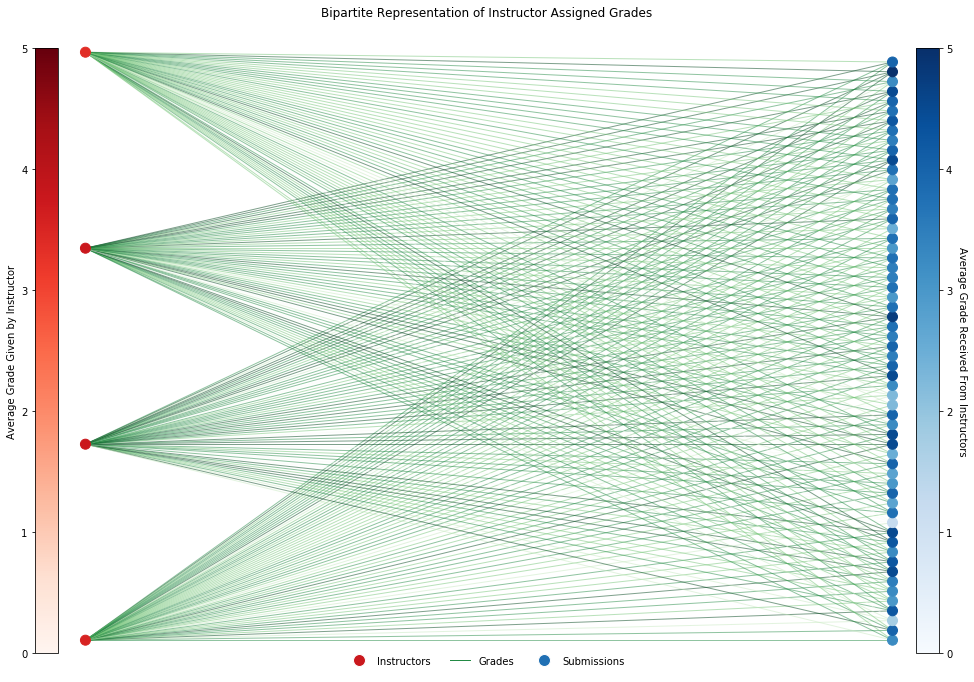

In [236]:
# BIPARTITE VISUALIZATION OF INSTRUCTOR GRADES

## update node positions
pos = dict()
pos.update( (n, (1, i * len(reports)/(len(instructors)-1))) for i, n in enumerate(instructors) )
pos.update( (n, (2, i)) for i, n in enumerate(reports) )
fig, ax = plt.subplots(1,figsize=(16,12))

## draw nodes
weights = [ 0 if x[1] == 0 else x[1] / I.degree(x[0]) for x in I.degree(instructors, weight='grade') ]
nx.draw_networkx_nodes(I, pos, nodelist=instructors.tolist(), node_color=weights, cmap=plt.cm.Reds,node_size=100, label='instructors', vmin=0, vmax=5)
weights = [ 0 if x[1] == 0 else x[1] / I.degree(x[0]) for x in I.degree(reports, weight='grade') ]
nx.draw_networkx_nodes(I, pos, nodelist=reports.tolist(), node_color=weights, cmap=plt.cm.Blues, node_size=100, label='submissions', vmin=0, vmax=5)

## draw edges
edges,weights = zip(*nx.get_edge_attributes(I,'grade').items())
nx.draw_networkx_edges(I, pos, edgelist=edges, edge_color=weights, alpha=0.5, label='grade', edge_cmap=plt.cm.Greens)

## instructor colorbar
instructor_colors = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin = 0, vmax=5))
cbaxes = fig.add_axes([0.12, 0.15, 0.02, 0.7])
student_cb = fig.colorbar(instructor_colors, cax=cbaxes)
cbaxes.yaxis.set_label_position('left')
cbaxes.yaxis.set_ticks_position('left')
student_cb.set_label('Average Grade Given by Instructor')

## submission colorbar
submission_colors = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=5))
cbaxes = fig.add_axes([0.885, 0.15, 0.02, 0.7])
submission_cb = fig.colorbar(submission_colors, cax=cbaxes)
submission_cb.set_label('Average Grade Received From Instructors', rotation=-90, labelpad=15)

## legend
line1 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=plt.cm.Reds(0.75), markersize=12)
line2 = Line2D([0], [0], color=plt.cm.Greens(0.75), lw=1)
line3 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=plt.cm.Blues(0.75), markersize=12)
ax.legend([line1, line2, line3], ['Instructors', 'Grades', 'Submissions'], loc='lower center', frameon=False, ncol=3)

ax.axis('off')
ax.set_title('Bipartite Representation of Instructor Assigned Grades')
plt.savefig('figures/instructor_bipartite_final.png')
plt.show()

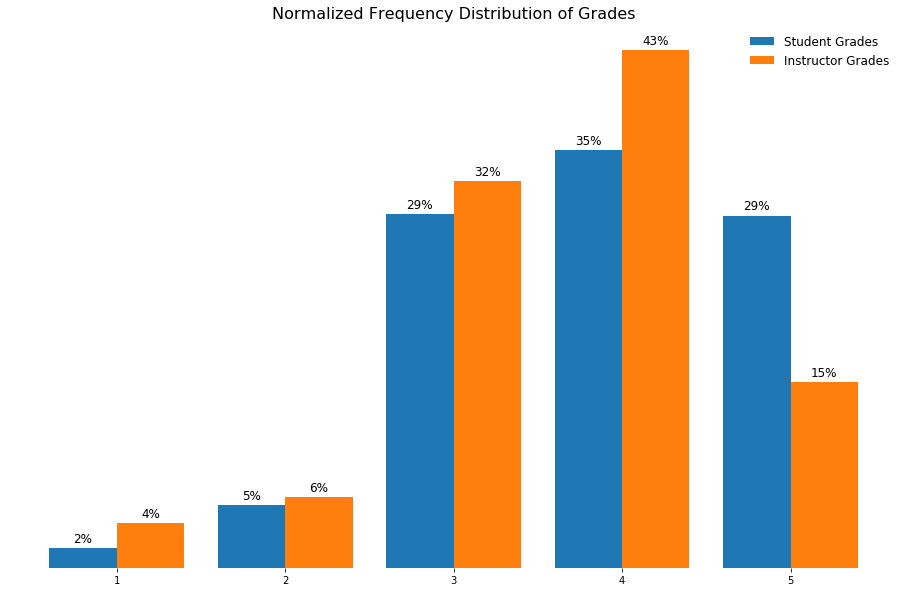

In [237]:
# Normalized Frequency Distribution of Grades
student_grade_freq = student_grades['grade'].value_counts() / student_grades.shape[0]
instructor_grade_freq = instructor_grades['grade'].value_counts() / instructor_grades.shape[0]

freq_dist_df = pd.DataFrame(data={ 'student_grades': student_grade_freq, 'instructor_grades': instructor_grade_freq}).sort_index()

ax = freq_dist_df.plot(kind='bar', width=0.8, figsize=(16,10))
ax.set_title('Normalized Frequency Distribution of Grades', fontsize=16)
ax.get_yaxis().set_ticks([])
ax.legend(['Student Grades', 'Instructor Grades'], fontsize=12, frameon=False)
for spine in ax.spines.values():
    spine.set_visible(False)
for p in ax.patches:
    ax.annotate(str(int(round(p.get_height() * 100))) + '%', (p.get_width()/2 + p.get_x(), p.get_height() + .005), ha='center', fontsize=12)

plt.xticks(rotation=0)
plt.savefig('figures/grade_frequency_dist_final.png')
plt.show()

## Simple Mean Model

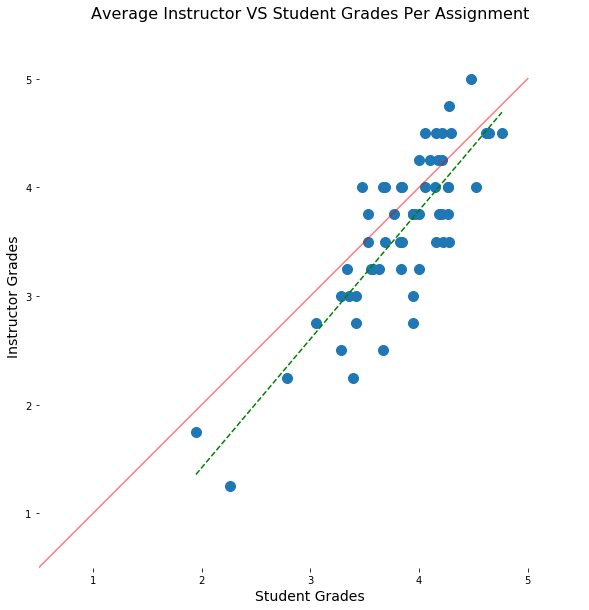

In [238]:
# Correlation Between Instructor and Student Grades
avg_student_grades = student_grades[['report_id', 'grade']].groupby('report_id').mean()
avg_instructor_grades = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()
avg_grades_df = pd.DataFrame(data={
        'student_grades': avg_student_grades['grade'],
        'instructor_grades': avg_instructor_grades['grade']
    }).sort_values('student_grades')

ax = avg_grades_df.plot(kind='scatter', s=100, x='student_grades', y='instructor_grades',figsize=(10,10))
ax.set_title('Average Instructor VS Student Grades Per Assignment', fontsize=16)
ax.set_ylim((.5, 5.5))
ax.set_xlim((.5, 5.5))
ax.get_yaxis().set_ticks([1,2,3,4,5])
ax.get_xaxis().set_ticks([1,2,3,4,5])
ax.set_ylabel('Instructor Grades', fontsize=14)
ax.set_xlabel('Student Grades', fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
for spine in ax.spines.values():
    spine.set_visible(False)

x = np.linspace(0,5,100)
ax.plot(x, x, '-r', alpha=0.5)

x = avg_grades_df['student_grades']
y = avg_grades_df['instructor_grades']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x , p(x),"g--")

plt.savefig('figures/mean_grade_correlation_final.png')
plt.show()

In [239]:
# Calculate Correlation Coefficient
avg_student_grades = student_grades[['report_id', 'grade']].groupby('report_id').mean()
avg_instructor_grades = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()

np.corrcoef(avg_instructor_grades['grade'], avg_student_grades['grade'])

array([[1.        , 0.82765331],
       [0.82765331, 1.        ]])

# Iterative Ranking Model

Weighted Mean:

$$Q_x = \frac{\sum_{i \in U_x} R_i r_{ix}}{\sum_{i \in U_x} R_i}$$

Pearson Correlation Coefficient:

$$TR_i = \frac{1}{k_i} \sum_{x \in O_i} (\frac{r_{ix} - \bar{r}_i}{\sigma_{r_i}}) (\frac{Q_x - \bar{Q}_i}{\sigma_{Q_i}})$$

Reputation Redistribution:

$$R_i = TR_i^\theta \frac{\sum_j TR_j}{\sum_j TR_j^\theta}$$

Change of quality:

$$\left|{Q - Q^\prime} \right| = \frac{1}{M} \sum_{l \in O} (Q_l - Q_l^\prime)^2$$

In [240]:
# Initialize Working Student Graph
students = student_reports['student_id'].unique()
reports = student_reports['report_id'].unique()
grades = [tuple([x[0], x[1], { 'grade': x[2] }]) for x in student_grades.values]

B = nx.Graph()
B.add_nodes_from(students, reputation=0, bipartite=0)
B.add_nodes_from(reports, quality=0, bipartite=1)
B.add_edges_from(grades)

## initialize reputations
for student_id in students:
    init_reputation = B.degree(student_id) / len(reports)
    nx.set_node_attributes(B, {student_id: init_reputation}, 'reputation')

In [257]:
# Initialize parameters
theta = 1
delta = 0.0001

In [258]:
# Calculate delta
def get_student_grades(G):
    avg_student_grades = pd.DataFrame([(x, y['quality']) for x,y in G.nodes(data=True) if 'quality' in y], columns=['report_id', 'grade'])
    return avg_student_grades.sort_values(by='report_id')['grade']

In [259]:
# Calculate error
def get_student_error(G):
    avg_student_grades = pd.DataFrame([(x, y['quality']) for x,y in B.nodes(data=True) if 'quality' in y], columns=['report_id', 'grade'])
    avg_student_grades = avg_student_grades.set_index('report_id')
    avg_instructor_grades = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()
    avg_grades_df = pd.DataFrame(data={
        'student_grades': avg_student_grades['grade'],
        'instructor_grades': avg_instructor_grades['grade']
    })

    return r2_score(avg_grades_df['instructor_grades'], avg_grades_df['student_grades'])


In [260]:
q_prime = get_student_grades(B)
q_change = 0
time_step = 0
r2_df = pd.DataFrame(columns=['time', 'r2'])

# Iterate Time Steps
while time_step < 2 or q_change > delta:
    
    # update quality of reports
    for report_id in reports:
        grades, reputations = list(zip(*[(grade, B.nodes[v]['reputation']) for u,v,grade in B.edges(report_id, data='grade')]))
        quality = np.average(grades, weights=reputations)
        nx.set_node_attributes(B, {report_id: quality}, 'quality')
        
    # calculate temporal reputation
    TR = []
    for student_id in students:
        if (B.degree(student_id) > 0):
            grades, qualities = list(zip(*[(grade, B.nodes[v]['quality']) for u,v,grade in B.edges(student_id, data='grade')]))
            tr = np.corrcoef(grades, qualities)[0][1]
            TR.append(tr if tr > 0 else 0)
        else:
            TR.append(0)
    
    # redistribute temporal reputation
    R = np.power(TR, theta) * np.sum(TR) / np.sum(np.power(TR, theta))
    for i, student_id in enumerate(students):
        nx.set_node_attributes(B, {student_id: R[i]}, 'reputation')
        
    # Calculate change of quality
    q = get_student_grades(B)
    q_change = (1 / q.shape[0]) * np.sum((q - q_prime)**2)
    q_prime = q
    time_step = time_step+1     

In [261]:
# Calculate Correlation Coefficient of Student Reputation and Instructor Grades
student_reputations = pd.DataFrame([(x, y['reputation']) for x,y in B.nodes(data=True) if 'reputation' in y], columns=['student_id', 'reputation'])
student_grades = pd.DataFrame([(x, y['quality']) for x,y in B.nodes(data=True) if 'quality' in y], columns=['report_id', 'student_grade'])
avg_instructor_grades = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()

student_reputations_reports = pd.merge(left=student_reputations,right=student_reports, left_on='student_id', right_on='student_id')
reputation_instructor_grades = pd.merge(left=student_reputations_reports, right=avg_instructor_grades, left_on='report_id', right_on='report_id')
results_df = pd.merge(left=reputation_instructor_grades, right=student_grades, left_on='report_id', right_on='report_id')

print('Reputation Correlation to Instructor Grade:')
print(np.corrcoef(results_df['reputation'], results_df['grade']), '\n')
print('Student Grade Correlation to Instructor Grade:')
print(np.corrcoef(results_df['student_grade'], results_df['grade']), '\n')
print('Student Reputation correlation to Student Grade:')
print(np.corrcoef(results_df['reputation'], results_df['student_grade']), '\n')

Reputation Correlation to Instructor Grade:
[[1.         0.36211985]
 [0.36211985 1.        ]] 

Student Grade Correlation to Instructor Grade:
[[1.         0.81901701]
 [0.81901701 1.        ]] 

Student Reputation correlation to Student Grade:
[[1.         0.41086076]
 [0.41086076 1.        ]] 



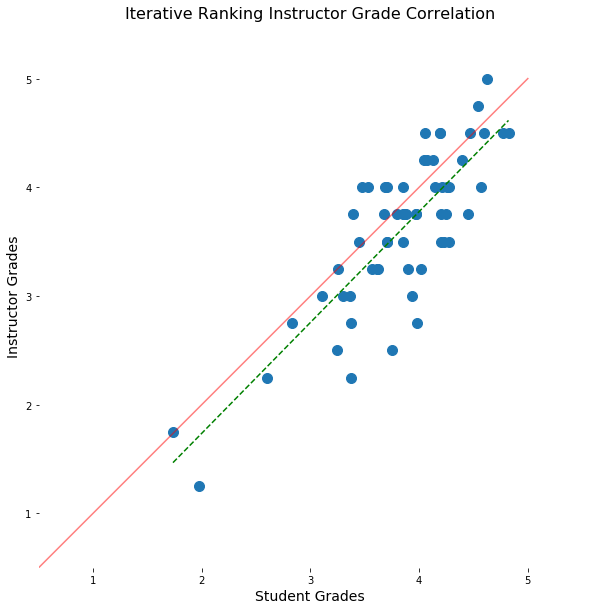

In [262]:
# Correlation Between Instructor and Student Grades
avg_student_grades = pd.DataFrame([(x, y['quality']) for x,y in B.nodes(data=True) if 'quality' in y], columns=['report_id', 'grade'])
avg_student_grades = avg_student_grades.set_index('report_id')
avg_instructor_grades = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()
avg_grades_df = pd.DataFrame(data={
        'student_grades': avg_student_grades['grade'],
        'instructor_grades': avg_instructor_grades['grade']
    }).sort_values('student_grades')

ax = avg_grades_df.plot(kind='scatter', s=100, x='student_grades', y='instructor_grades',figsize=(10,10))
ax.set_title('Iterative Ranking Instructor Grade Correlation', fontsize=16)
ax.set_ylim((.5, 5.5))
ax.set_xlim((.5, 5.5))
ax.get_yaxis().set_ticks([1,2,3,4,5])
ax.get_xaxis().set_ticks([1,2,3,4,5])
ax.set_ylabel('Instructor Grades', fontsize=14)
ax.set_xlabel('Student Grades', fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
for spine in ax.spines.values():
    spine.set_visible(False)

x = np.linspace(0,5,100)
ax.plot(x, x, '-r', alpha=0.5)

x = avg_grades_df['student_grades']
y = avg_grades_df['instructor_grades']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x , p(x),"g--")

plt.savefig('figures/ir_grade_correlation_final.png')
plt.show()

## References

1. Balfour, S. P. (2013). Assessing Writing in MOOCs: Automated Essay Scoring and Calibrated Peer Review™. Research & Practice in Assessment, 8, 40-48.
1. Davies, P. (2000). Computerized peer assessment. Innovations in education and training international, 37(4), 346-355.
1. Falchikov, N., & Goldfinch, J. (2000). Student peer assessment in higher education: A meta-analysis comparing peer and teacher marks. Review of educational research, 70(3), 287-322.
1. Flanagin, A. J., Metzger, M. J., Pure, R., & Markov, A. (2011, January). User-generated ratings and the evaluation of credibility and product quality in ecommerce transactions. In 2011 44th Hawaii International Conference on System Sciences (pp. 1-10). IEEE.
1. Flanagin, A. J., Metzger, M. J., Pure, R., Markov, A., & Hartsell, E. (2014). Mitigating risk in ecommerce transactions: perceptions of information credibility and the role of user-generated ratings in product quality and purchase intention. Electronic Commerce Research, 14(1), 1-23.
1. Kulkarni, C. E., Bernstein, M. S., & Klemmer, S. R. (2015, March). PeerStudio: rapid peer feedback emphasizes revision and improves performance. In Proceedings of the second (2015) ACM conference on learning@ scale (pp. 75-84). ACM.
1. Liao, H., Zeng, A., Xiao, R., Ren, Z. M., Chen, D. B., & Zhang, Y. C. (2014). Ranking reputation and quality in online rating systems. PloS one, 9(5), e97146.
1. Piech, C., Huang, J., Chen, Z., Do, C., Ng, A., & Koller, D. (2013). Tuned models of peer assessment in MOOCs. arXiv preprint arXiv:1307.2579.
1. Strachan, I. B., & Wilcox, S. (1996). Peer and self assessment of group work: Developing an effective response to increased enrolment in a third‐year course in microclimatology. Journal of Geography in Higher Education, 20(3), 343-353.
1. Rohs, M., & Ganz, M. (2015). MOOCs and the claim of education for all: A disillusion by empirical data. The International Review of Research in Open and Distributed Learning, 16(6).
1. Topping, K. J. (2009). Peer assessment. Theory into practice, 48(1), 20-27.
1. Vozniuk, Andrii & Holzer, Adrian & Gillet, Denis. (2016). Peer Assessment Dataset. Journal of Learning Analytics. 3. 322-324. 10.18608/jla.2016.32.18.
